# Tarea 2 - Redes Neuronales
Integrantes: 
- Matías Aguilera
- Jonas Oviedo
- Natalia Romero

## Introducción
En este trabajo, se desarrolla y entrena una red neuronal para clasificar imágenes utilizando el dataset CIFAR-10. Este dataset consta de 60000 imágenes a color de tamaño 32x32 píxeles distribuidas en 10 clases diferentes, con 6000 imágenes por clase. Las clases incluyen categorías como aviones, automóviles, aves, gatos, ciervos, perros, ranas, caballos, barcos y camiones.

## Importación de librerías
En primer lugar, se importan las librerías numpy y pandas, las cuales nos ayudarán a trabajar con los datos. Además, se importa la librería matplotlib que será de ayuda para graficar los resultados obtenidos y generar análisis en base a su interpretación. Finalmente se importa la librería time que será de importancia para el calculo de tiempo de entrenamiento.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time

## Carga del dataset CIFAR-10
El dataset **CIFAR-10** (Canadian Institute For Advanced Research) es uno de los datasets más utilizados en computer vision. Consiste en 60000 imágenes en color de 32x32 px distribuidas en 10 clases, con 6000 imágenes por clase. El conjunto de datos está dividido en una parte de train y una parte de test, con 50000 y 10000 imágenes, respectivamente.


Las clases del dataset son las siguientes:
1. Avión
2. Automóvil
3. Pájaro
4. Gato
5. Ciervo
6. Perro
7. Rana
8. Caballo
9. Barco
10. Camión

Fuente: [](https://www.cs.toronto.edu/~kriz/cifar.html)

### Train
Se cargan los datos de entrenamiento desde un archivo CSV. Además, se convierten los datos a un array de numpy y se redimensionan a 32x32 píxeles con 3 canales de color (RGB).

In [2]:
train = pd.read_csv('data/train_data.csv')
X_train = train.drop(columns=["ID", "label"]).values.reshape(-1, 32, 32, 3)
y_train = train["label"].values

### Test
Al igual que en train, se cargan los datos de entrenamiento y se redimensiona.

In [3]:
test = pd.read_csv('data/test_data.csv')
X_test = test.drop(columns=["ID"]).values.reshape(-1, 32, 32, 3)

### Normalización de los datos
Para mejorar el rendimiento del modelo a crear, se necesitan normalizar los datos de entrada. Lo que hace esta técnica, es escalar los valores de los píxeles a un rango más manejable, lo que puede acelerar el proceso de entrenamiento y mejorar la precisión del modelo. Los valores de píxeles están en un rango de 0 a 255. Por lo que al dividir estos valores por 255, se escalan a un rango de 0 a 1.

In [4]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

### Aplanamiento de las imágenes
Los datos deben aplanarse de su formato original (alto, ancho, canales) a un formato bidimensional (número de muestras, características).

In [5]:
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

### One-Hot
Se codifican las clases para que sean procesadas por la red. De tal forma que, se crea un vector de dos posibles valores 0 o 1, donde solo tendrá el valor de 1 en el índice de la clase correspondiente, y las demás posiciones estarán en 0.

In [6]:
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]

## Estadísticas del dataset
Para asegurarnos de que las imágenes estén correctamente pre procesadas y tener una idea de su distribución. Se crea la siguiente función que calcula y muestra las estadísticas básicas de las imágenes del dataset.

In [7]:
def display_statistics(images):
    print("Mean:", np.mean(images, axis=(0, 1, 2))) #valor promedio de los pixeles en todas las imagenes
    print("Median:", np.median(images, axis=(0, 1, 2))) #mediana de los valores de pixeles en las imagenes
    print("Std Dev:", np.std(images, axis=(0, 1, 2))) #desviación estandar de los valores de pixeles en las imagenes 
    print("Min:", np.min(images, axis=(0, 1, 2))) # valor minimo de los pixeles en las imagenes
    print("Max:", np.max(images, axis=(0, 1, 2))) #valor maximo de los pixeles en las imagenes 

In [8]:
print("Training data statistics:")
display_statistics(X_train)
print("\nTest data statistics:")
display_statistics(X_test)

Training data statistics:
Mean: [125.42750239 123.08609986 114.02829599]
Median: [124. 121. 105.]
Std Dev: [62.94400534 62.00992365 66.65793449]
Min: [0 0 0]
Max: [255 255 255]

Test data statistics:
Mean: [125.42107715 123.02373958 114.04102778]
Median: [123. 120. 105.]
Std Dev: [63.16802848 62.37071166 66.97845289]
Min: [0 0 0]
Max: [255 255 255]


## Visualización de imágenes aleatorias
A continuación, se muestran imágenes aleatorias mediante la función `plot_random_images` que selecciona y muestra un conjunto de imágenes aleatorias del dataset junto con sus etiquetas correspondientes.

In [9]:
def plot_random_images(images, labels, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.imshow(images[idx].astype('uint8'))
        ax.title.set_text(labels[idx])
        ax.axis('off')
    plt.show()

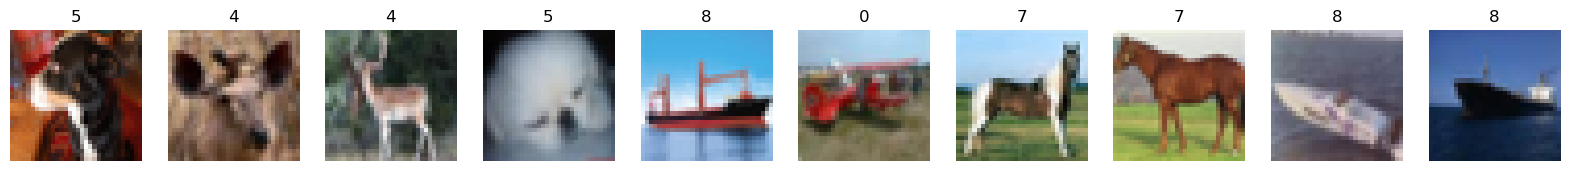

In [50]:
plot_random_images(X_train, y_train)

## Distribución de clases
Se muestra como se distribuyen las 10 clases del dataset.

In [53]:
def display_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Clases')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de clases')
    plt.show()

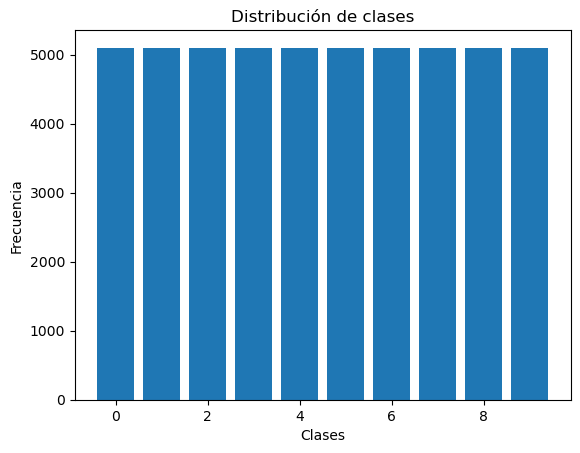

In [54]:
display_class_distribution(y_train)

## Red neuronal
La arquitectura de la red neuronal a implementar cuenta con múltiples capas ocultas. Cada capa oculta tendrá un número específico de neuronas, y la capa de salida tendrá 10 neuronas, una para cada clase del dataset CIFAR-10. Utilizaremos la función de activación ReLU para las capas ocultas y softmax para la capa de salida. Además, se implementará regularización L1/L2 para evitar el overfitting, Early Stopping, Learning Rate Scheduler, etc.

### Arquitectura
Se define la arquitectura de lad red neuronal, especificando el tamaño de las capas de entrada, ocultas y de salida.

In [13]:
#arquitectura de la red
input_size = 32 * 32 * 3 # capa input
hidden_size1 = 1024 #capa oculta 1
hidden_size2 = 512 #capa oculta 2
hidden_size3 = 128 #capa oculta 3
output_size = num_classes #capa output

### Inicialización de pesos y bias
Se inicializan los pesos utilizando la técnica de inicialización de He, que ayuda a mantener la variabilidad de los gradientes a través de las capas de la red.  

In [14]:
np.random.seed(42) #semilla
W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2. / input_size)
b1 = np.zeros((1, hidden_size1))
W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2. / hidden_size1)
b2 = np.zeros((1, hidden_size2))
W3 = np.random.randn(hidden_size2, hidden_size3) * np.sqrt(2. / hidden_size2)
b3 = np.zeros((1, hidden_size3))
W4 = np.random.randn(hidden_size3, output_size) * np.sqrt(2. / hidden_size3)
b4 = np.zeros((1, output_size))

In [15]:
m_W1, v_W1 = np.zeros_like(W1), np.zeros_like(W1)
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
m_W2, v_W2 = np.zeros_like(W2), np.zeros_like(W2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)
m_W3, v_W3 = np.zeros_like(W3), np.zeros_like(W3)
m_b3, v_b3 = np.zeros_like(b3), np.zeros_like(b3)
m_W4, v_W4 = np.zeros_like(W4), np.zeros_like(W4)
m_b4, v_b4 = np.zeros_like(b4), np.zeros_like(b4)

### Batch Normalization
Batch normalization es una técnica utilizada para mejorar la estabilidad y la velocidad del entrenamiento de redes neuronales. Esta técnica normaliza las activaciones de una capa para cada mini-batch, lo que ayuda a mitigar problemas como el vanish y exploding del gradiente, además de permitir un uso de tasas de aprendizaje más altas.


Para cada mini-batch de activaciones $x$, batch normalization se realizan los siguientes pasos:

1. **Normalización**:
   $$
   \hat{x} = \frac{x - \mu_{\text{batch}}}{\sqrt{\sigma_{\text{batch}}^2 + \epsilon}}
   $$
   Donde:
   - $\mu_{\text{batch}}$ es la media del mini-batch.
   - $\sigma_{\text{batch}}^2$ es la varianza del mini-batch.
   - $\epsilon$ es un pequeño valor añadido para la estabilidad numérica.
2. **Escalado y Desplazamiento**:
   $$ y = \gamma \hat{x} + \beta $$
   Donde:
   - $\gamma$ es el parámetro de escala entrenable.
   - $\beta$ es el parámetro de desplazamiento entrenable.

#### Parámetros de Batch Normalization

Para cada capa donde aplicamos batch normalization, necesitamos inicializar dos parámetros clave:

- **Gamma ($\gamma$)**: Parámetro de escala que permite a la red ajustar la varianza de la activación.
- **Beta ($\beta$)**: Parámetro de desplazamiento que permite a la red ajustar la media de la activación.

Estos parámetros son entrenables y se actualizan durante el proceso de entrenamiento de la red neuronal.

In [16]:
# inicialización de parametros del batch normalization
gamma1 = np.ones((1, hidden_size1))
beta1 = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2 = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3 = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4 = np.zeros((1, output_size))

In [17]:
# hiperparametros del batch normalization
epsilon = 1e-8
momentum = 0.9

In [18]:
running_mean1 = np.zeros((1, hidden_size1))
running_var1 = np.ones((1, hidden_size1))
running_mean2 = np.zeros((1, hidden_size2))
running_var2 = np.ones((1, hidden_size2))
running_mean3 = np.zeros((1, hidden_size3))
running_var3 = np.ones((1, hidden_size3))
running_mean4 = np.zeros((1, output_size))
running_var4 = np.ones((1, output_size))

#### Batch Normalization (Forward Pass)
Se implementa la función `batch_norm_forward` para el forward pass del batch normalization.

**Input:**
- `Z:` Activaciones de la capa anterior.
- `gamma:` Parámetro de escala.
- `beta:` Parámetro de desplazamiento.
- `running_mean:` Media en ejecución (promedio acumulado).
- `running_var:` Varianza en ejecución (promedio acumulado).
- `training:` Indicador de modo de entrenamiento (true/false).

**Modo de entrenamiento**:

1. **Cálculo de la media y varianza del batch**:
   $$
   \text{batch\_mean} = \frac{1}{m} \sum_{i=1}^m Z_i
   $$

   $$
   \text{batch\_var} = \frac{1}{m} \sum_{i=1}^m (Z_i - \text{batch\_mean})^2
   $$

2. **Normalización de las activaciones**:
   $$
   Z_{\text{normalized}} = \frac{Z - \text{batch\_mean}}{\sqrt{\text{batch\_var} + \epsilon}}
   $$
**Output:**
- `out:` Activaciones normalizadas y ajustadas por gamma y beta.
- `cache:` Tupla de valores necesarios para el backward pass.
- `running_mean:` Media en ejecución actualizada.
- `running_var:` Varianza en ejecución actualizada.

In [19]:
# Batch normalization forward pass
def batch_norm_forward(Z, gamma, beta, running_mean, running_var, training):
    if training:
        batch_mean = np.mean(Z, axis=0)
        batch_var = np.var(Z, axis=0)
        Z_normalized = (Z - batch_mean) / np.sqrt(batch_var + epsilon)
        out = gamma * Z_normalized + beta

        running_mean = momentum * running_mean + (1 - momentum) * batch_mean
        running_var = momentum * running_var + (1 - momentum) * batch_var

        cache = (Z, Z_normalized, batch_mean, batch_var, gamma, beta)
        return out, cache, running_mean, running_var
    else:
        Z_normalized = (Z - running_mean) / np.sqrt(running_var + epsilon)
        out = gamma * Z_normalized + beta
        return out, None, running_mean, running_var

#### Batch Normalization (Backward Pass)
Se implementa la función `batch_norm_backward` para el backward pass del batch normalization.

**Input:**
- `dout:` Gradiente de la pérdida con respecto a la salida de la capa de batch normalization.
- `cache:` Tupla de valores almacenados durante el fordward pass necesarios para este backward.

**Proceso:**
- **Gradiente con respecto a $\hat{Z} $**:

  $$
  dZ_{\text{normalized}} = dout \cdot \gamma
  $$

- **Gradiente con respecto a la varianza del lote**:

  $$
  dvar = \sum dZ_{\text{normalized}} \cdot (Z - \text{batch\_mean}) \cdot -0.5 \cdot ( \text{batch\_var} + \epsilon )^{-1.5}
  $$

- **Gradiente con respecto a la media del lote**:

  $$
  dmean = \sum dZ_{\text{normalized}} \cdot -\frac{1}{\sqrt{\text{batch\_var} + \epsilon}} + dvar \cdot \frac{\sum -2 \cdot (Z - \text{batch\_mean})}{m}
  $$

- **Gradiente con respecto a \(Z\)**:

  $$
  dZ = dZ_{\text{normalized}} \cdot \frac{1}{\sqrt{\text{batch\_var} + \epsilon}} + dvar \cdot \frac{2 \cdot (Z - \text{batch\_mean})}{m} + dmean \cdot \frac{1}{m}
  $$

- **Gradiente con respecto a \(\gamma\)**:

  $$
  dgamma = \sum dout \cdot Z_{\text{normalized}}
  $$

- **Gradiente con respecto a \(\beta\)**:

  $$
  dbeta = \sum dout
  $$


**Output:**
- `dZ:` Gradiente de la pérdida con respecto a la entrada de la capa de batch normalization.
- `dgamma:` Gradiente de la pérdida con respecto al parámetro de escala $γ$.
- `dbeta:` Gradiente de la pérdida con respecto al parámetro de desplazamiento $β$.

In [20]:
# Batch normalization backward pass
def batch_norm_backward(dout, cache):
    Z, Z_normalized, batch_mean, batch_var, gamma, beta = cache
    m = Z.shape[0]

    dZ_normalized = dout * gamma
    dvar = np.sum(dZ_normalized * (Z - batch_mean) * -0.5 * np.power(batch_var + epsilon, -1.5), axis=0)
    dmean = np.sum(dZ_normalized * -1 / np.sqrt(batch_var + epsilon), axis=0) + dvar * np.mean(-2 * (Z - batch_mean), axis=0)

    dZ = dZ_normalized / np.sqrt(batch_var + epsilon) + dvar * 2 * (Z - batch_mean) / m + dmean / m
    dgamma = np.sum(dout * Z_normalized, axis=0)
    dbeta = np.sum(dout, axis=0)

    return dZ, dgamma, dbeta

### Funciones de activación

#### Función de activación ReLU
La función de activación ReLU (Rectified Linear Unit) se utiliza comúnmente en redes neuronales debido a su simplicidad y efectividad. ReLU activa las neuronas en función de si su valor es mayor que cero.
- **Función ReLU**:
  - `relu(Z)`: Aplica la función de activación ReLU a las entradas \( Z \).
    
    $$
    \text{ReLU}(Z) = \max(0, Z)
    $$

  - Esta función convierte todas las entradas negativas en cero y deja las entradas positivas sin cambios, lo que introduce no linealidad en la red.

- **Derivada de ReLU**:
  - `relu_derivative(Z)`: Calcula la derivada de la función ReLU.

    $$
    \text{ReLU}'(Z) =
    \begin{cases} 
    1 & \text{si } Z > 0 \\
    0 & \text{si } Z \leq 0 
    \end{cases}
    $$

In [21]:
#  ReLU
def relu(Z):
    return np.maximum(0, Z)

In [22]:
def relu_derivative(Z):
    return Z > 0

#### Función de activación Softmax
La función de activación Softmax se utiliza comúnmente en la capa de salida de una red neuronal para problemas de clasificación multiclase. Transforma las salidas de la red en probabilidades, asignando un valor entre 0 y 1 a cada clase, y asegurando que la suma de todas las probabilidades sea 1.
- **Softmax**:
  - `softmax(Z)`: Aplica la función Softmax a las entradas $ Z$.
    
    $$
    \text{softmax}(Z_i) = \frac{\exp(Z_i - \max(Z))}{\sum_j \exp(Z_j - \max(Z))}
    $$

  - La función calcula primero el exponente de cada valor en $Z $ después de restar el valor máximo en cada fila. Restar el valor máximo mejora la estabilidad numérica.
  - Luego, divide cada exponente por la suma de todos los exponentes en la misma fila, transformando las salidas en probabilidades.


In [23]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / exp_Z.sum(axis=1, keepdims=True)

### Regularización y función de pérdida
La regularización es una técnica utilizada para prevenir el overfitting en los modelos de redes neuronales. Se crea una función que inicializa los parámetros de regularización L1 y L2 y otra la función de pérdida que incluye la pérdida de entropía cruzada junto con las regularizaciones L1 y L2.
- **Regularización L1:** Penaliza la suma de los valores absolutos de los pesos. Ayuda a inducir esparsidad en los pesos, forzando algunos de ellos a ser exactamente cero.

- **Regularización L2:** Penaliza la suma de los cuadrados de los pesos. Ayuda a prevenir grandes valores de los pesos, promoviendo pesos más pequeños y distribuidos uniformemente.
- **Función de pérdida:**
- - **Pérdida de entropía cruzada**: $$ \text{cross\_entropy\_loss} = -\frac{1}{m} \sum (Y \cdot \log(Y_{\text{hat}} + 1e-9))$$
- - **Pérdida L1**:  $$\text{l1\_loss} = \lambda_{L1} \sum |W|$$
- - **Pérdida L2**: $$\text{l2\_loss} = \lambda_{L2} \sum W^2 / 2$$
- - **Pérdida Total**: $$\text{total\_loss} = \text{cross\_entropy\_loss} + \text{l1\_loss} + \text{l2\_loss} $$

In [24]:
# parametros de regularizacion
lambda_l1 = 0.000001  # L1 regularization
lambda_l2 = 0.000001  #  L2 regularization

In [25]:
def compute_loss(Y, Y_hat, W1, W2, W3, W4, lambda_l1, lambda_l2):
    m = Y.shape[0]
    cross_entropy_loss = -np.sum(Y * np.log(Y_hat + 1e-9)) / m
    l1_loss = lambda_l1 * (np.sum(np.abs(W1)) + np.sum(np.abs(W2)) + np.sum(np.abs(W3)) + np.sum(np.abs(W4)))
    l2_loss = lambda_l2 * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2) + np.sum(W4**2) ) / 2
    return cross_entropy_loss + l1_loss + l2_loss

### Optimizador Adam
El optimizador Adam (Adaptive Moment Estimation) es uno de los métodos de optimización más utilizados en el entrenamiento de redes neuronales debido a su eficiencia y adaptabilidad. Combina las ventajas de dos otros métodos de optimización: AdaGrad y RMSProp.
#### Función de actualización 
**Parámetros del optimizador:**
- `initial_learning_rate:` La tasa de aprendizaje inicial.    learning_rate: La tasa de aprendizaje utilizada en el momento de la actualización.
- `beta1_adam:` Parámetro de decaimiento exponencial para el promedio móvil de los gradientes.
- `beta2_adam:` Parámetro de decaimiento exponencial para el promedio móvil de los cuadrados de los gradientes.
- `eps` Pequeño valor añadido para evitar la división por cero.

**Variables de momento:**
- `m:` Promedio móvil de los gradientes.
- `v:` Promedio móvil de los cuadrados de los gradientes.

**Actualización:**

- **Promedio móvil de los gradientes**:

  $$
  m = \beta_1 \cdot m + (1 - \beta_1) \cdot \text{grad}
  $$

- **Promedio móvil de los cuadrados de los gradientes**:

  $$
  v = \beta_2 \cdot v + (1 - \beta_2) \cdot (\text{grad}^2)
  $$

- **Corrección de sesgo para el promedio móvil de los gradientes**:

  $$
  \hat{m} = \frac{m}{1 - \beta_1^t}
  $$

- **Corrección de sesgo para el promedio móvil de los cuadrados de los gradientes**:

  $$
  \hat{v} = \frac{v}{1 - \beta_2^t}
  $$

- **Actualización del parámetro**:

  $$
  \text{param} = \text{param} - \text{learning\_rate} \cdot \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}
  $$

In [26]:
# Adam Optimizer 
initial_learning_rate = 0.0015
learning_rate = initial_learning_rate
beta1_adam = 0.9
beta2_adam = 0.999
eps = 1e-8

In [27]:
m_gamma1, v_gamma1 = np.zeros_like(gamma1), np.zeros_like(gamma1)
m_beta1, v_beta1 = np.zeros_like(beta1), np.zeros_like(beta1)
m_gamma2, v_gamma2 = np.zeros_like(gamma2), np.zeros_like(gamma2)
m_beta2, v_beta2 = np.zeros_like(beta2), np.zeros_like(beta2)
m_gamma3, v_gamma3 = np.zeros_like(gamma3), np.zeros_like(gamma3)
m_beta3, v_beta3 = np.zeros_like(beta3), np.zeros_like(beta3)
m_gamma4, v_gamma4 = np.zeros_like(gamma4), np.zeros_like(gamma4)
m_beta4, v_beta4 = np.zeros_like(beta4), np.zeros_like(beta4)

In [28]:
# Adam optimizer update
def adam_update(param, grad, m, v, t, learning_rate, beta1, beta2, eps):
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= learning_rate * m_hat / (np.sqrt(v_hat) + eps)
    return param, m, v

### Early Stopping
Early Stopping es una técnica utilizada durante el entrenamiento de redes neuronales para prevenir el overfitting. Esta técnica detiene el entrenamiento cuando la pérdida en el conjunto de validación deja de mejorar después de un número determinado de epochs.
- **Parámetros:**
- `patience:` Número de epochs que se espera antes de detener el entrenamiento si no hay mejora en la pérdida de validación.
- `min_delta:` Mínima mejora en la pérdida que se considera como una mejora significativa.

- **Atributos:**
- `best_loss:` La mejor pérdida de validación observada hasta ahora.
- `counter:` Contador de epochs sin mejora significativa en la pérdida de validación.

- **Método should_stop:**
- `val_loss:` La pérdida de validación en la epoch actual.
- - Compara la pérdida de validación actual con la mejor pérdida observada.
- - Si la pérdida actual es significativamente mejor (menor por al menos min_delta), se actualiza best_loss y se reinicia el contador.
- - Si no hay mejora significativa, se incrementa el contador.
- - Devuelve True si el contador alcanza el valor de patience, indicando que se debe detener el entrenamiento.

In [29]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

### Learning Rate Scheduler
Learning Rate Scheduler ajusta dinámicamente la tasa de aprendizaje durante el entrenamiento del modelo. Disminuir la tasa de aprendizaje cuando la pérdida de validación no mejora permite que la red converja mejor.
- **Parámetros:**
- `factor:` Factor por el cual se reduce la tasa de aprendizaje.
- `patience:` Número de épocas sin mejora en la pérdida de validación antes de reducir la tasa de aprendizaje.
- `min_lr:` La tasa de aprendizaje mínima que se puede alcanzar.

- **Atributos:**
- `best_loss:` La mejor pérdida de validación observada hasta ahora.
- `counter:` Contador de épocas sin mejora en la pérdida de validación.

- **Método schedule:**
- `val_loss:` La pérdida de validación en la época actual.
 - `current_lr:` La tasa de aprendizaje actual.
- - Compara la pérdida de validación actual con la mejor pérdida observada.
- - Si la pérdida actual mejora, actualiza best_loss y reinicia el contador.
- - Si no hay mejora, incrementa el contador.
- - Si el contador alcanza el valor de patience, reduce la tasa de aprendizaje, multiplicándola por factor, sin bajar de min_lr.

In [30]:
# Learning Rate Scheduler
class LearningRateScheduler:
    def __init__(self, factor=0.5, patience=10, min_lr=1e-6):
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_loss = np.inf
        self.counter = 0

    def schedule(self, val_loss, current_lr):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            new_lr = max(current_lr * self.factor, self.min_lr)
            print(f"Reducing learning rate from {current_lr} to {new_lr}")
            self.counter = 0
            return new_lr
        return current_lr

### Métricas de evaluación
Se implementa una función que calcula la precisión (precision), recall y exactitud (accuracy).
- **Precision:**

$$
\text{Precisión} = \frac{TP}{TP + FP}
$$

- **Recall:**

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- **Accuracy:**

$$
\text{Exactitud} = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}}
$$

In [31]:
def metrics(pred, true, num_classes):#
    precisions = []
    recalls = []
    accuracy = np.mean(pred == true)
    for cls in range(num_classes):
        tp = np.sum((pred == cls) & (true == cls))
        fp = np.sum((pred == cls) & (true != cls))
        fn = np.sum((pred != cls) & (true == cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        
    return precisions, recalls, accuracy

## Entrenamiento del modelo

### Configuración 
Se define el número de epochs para entrenar el modelo y la proporción de datos de entrenamiento que se utilizará para la validación.

In [32]:
epochs = 500
validation_split = 0.1

Se divide el dataset de entrenamiento en dos subconjuntos: uno para entrenamiento y otro para validación, basado en la proporción definida anteriormente.

In [33]:
val_size = int(len(X_train_flat) * validation_split)
X_val = X_train_flat[:val_size]
y_val = y_train_one_hot[:val_size]
X_train_flat = X_train_flat[val_size:]
y_train_one_hot = y_train_one_hot[val_size:]

In [34]:
train_losses = []
val_losses = []

In [35]:
early_stopping = EarlyStopping(patience=20, min_delta=0.001)
lr_scheduler = LearningRateScheduler(factor=0.5, patience=10, min_lr=1e-6)

### Implementación
Se entrena la red neuronal utilizando propagación hacia adelante, cálculo de pérdida, propagación hacia atrás, y actualizaciones de parámetros mediante el optimizador Adam. También se realiza la validación y se ajusta la tasa de aprendizaje.

In [36]:
start_time = time.time()

for epoch in range(epochs):
    # Forward propagation
    Z1 = np.dot(X_train_flat, W1) + b1
    Z1_bn, cache1, running_mean1, running_var1 = batch_norm_forward(Z1, gamma1, beta1, running_mean1, running_var1, training=True)
    A1 = relu(Z1_bn)
    Z2 = np.dot(A1, W2) + b2
    Z2_bn, cache2, running_mean2, running_var2 = batch_norm_forward(Z2, gamma2, beta2, running_mean2, running_var2, training=True)
    A2 = relu(Z2_bn)
    Z3 = np.dot(A2, W3) + b3
    Z3_bn, cache3, running_mean3, running_var3 = batch_norm_forward(Z3, gamma3, beta3, running_mean3, running_var3, training=True)
    A3 = relu(Z3_bn)
    Z4 = np.dot(A3, W4) + b4
    Z4_bn, cache4, running_mean4, running_var4 = batch_norm_forward(Z4, gamma4, beta4, running_mean4, running_var4, training=True)
    Y_hat = softmax(Z4_bn)
    
    # Compute loss
    loss = compute_loss(y_train_one_hot, Y_hat, W1, W2, W3, W4, lambda_l1, lambda_l2)
    train_losses.append(loss)
    
    # Backward propagation
    dZ4_bn = Y_hat - y_train_one_hot
    dZ4, dgamma4, dbeta4 = batch_norm_backward(dZ4_bn, cache4)
    dW4 = np.dot(A3.T, dZ4) / X_train_flat.shape[0] + lambda_l2 * W4
    db4 = np.sum(dZ4, axis=0, keepdims=True) / X_train_flat.shape[0]
    dA3 = np.dot(dZ4, W4.T)
    
    dZ3_bn = dA3 * relu_derivative(cache3[1])
    dZ3, dgamma3, dbeta3 = batch_norm_backward(dZ3_bn, cache3)
    dW3 = np.dot(A2.T, dZ3) / X_train_flat.shape[0] + lambda_l2 * W3
    db3 = np.sum(dZ3, axis=0, keepdims=True) / X_train_flat.shape[0]
    dA2 = np.dot(dZ3, W3.T)
    
    dZ2_bn = dA2 * relu_derivative(cache2[1])
    dZ2, dgamma2, dbeta2 = batch_norm_backward(dZ2_bn, cache2)
    dW2 = np.dot(A1.T, dZ2) / X_train_flat.shape[0] + lambda_l2 * W2
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_train_flat.shape[0]
    dA1 = np.dot(dZ2, W2.T)
    
    dZ1_bn = dA1 * relu_derivative(cache1[1])
    dZ1, dgamma1, dbeta1 = batch_norm_backward(dZ1_bn, cache1)
    dW1 = np.dot(X_train_flat.T, dZ1) / X_train_flat.shape[0] + lambda_l2 * W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_train_flat.shape[0
]
    #Actualización de pesos y bias utilizando el optimizador Adam
    t = epoch + 1
    W1, m_W1, v_W1 = adam_update(W1, dW1, m_W1, v_W1, t, learning_rate, beta1_adam, beta2_adam, eps)
    b1, m_b1, v_b1 = adam_update(b1, db1, m_b1, v_b1, t, learning_rate, beta1_adam, beta2_adam, eps)
    W2, m_W2, v_W2 = adam_update(W2, dW2, m_W2, v_W2, t, learning_rate, beta1_adam, beta2_adam, eps)
    b2, m_b2, v_b2 = adam_update(b2, db2, m_b2, v_b2, t, learning_rate, beta1_adam, beta2_adam, eps)
    W3, m_W3, v_W3 = adam_update(W3, dW3, m_W3, v_W3, t, learning_rate, beta1_adam, beta2_adam, eps)
    b3, m_b3, v_b3 = adam_update(b3, db3, m_b3, v_b3, t, learning_rate, beta1_adam, beta2_adam, eps)
    W4, m_W4, v_W4 = adam_update(W4, dW4, m_W4, v_W4, t, learning_rate, beta1_adam, beta2_adam, eps)
    b4, m_b4, v_b4 = adam_update(b4, db4, m_b4, v_b4, t, learning_rate, beta1_adam, beta2_adam, eps)
    gamma1, m_gamma1, v_gamma1 = adam_update(gamma1, dgamma1, m_gamma1, v_gamma1, t, learning_rate, beta1_adam, beta2_adam, eps)
    beta1, m_beta1, v_beta1 = adam_update(beta1, dbeta1, m_beta1, v_beta1, t, learning_rate, beta1_adam, beta2_adam, eps)
    gamma2, m_gamma2, v_gamma2 = adam_update(gamma2, dgamma2, m_gamma2, v_gamma2, t, learning_rate, beta1_adam, beta2_adam, eps)
    beta2, m_beta2, v_beta2 = adam_update(beta2, dbeta2, m_beta2, v_beta2, t, learning_rate, beta1_adam, beta2_adam, eps)
    gamma3, m_gamma3, v_gamma3 = adam_update(gamma3, dgamma3, m_gamma3, v_gamma3, t, learning_rate, beta1_adam, beta2_adam, eps)
    beta3, m_beta3, v_beta3 = adam_update(beta3, dbeta3, m_beta3, v_beta3, t, learning_rate, beta1_adam, beta2_adam, eps)
    gamma4, m_gamma4, v_gamma4 = adam_update(gamma4, dgamma4, m_gamma4, v_gamma4, t, learning_rate, beta1_adam, beta2_adam, eps)
    beta4, m_beta4, v_beta4 = adam_update(beta4, dbeta4, m_beta4, v_beta4, t, learning_rate, beta1_adam, beta2_adam, eps)
    
    # Validation forward propagation
    Z1_val = np.dot(X_val, W1) + b1
    Z1_val_bn, _, running_mean1, running_var1 = batch_norm_forward(Z1_val, gamma1, beta1, running_mean1, running_var1, training=False)
    A1_val = relu(Z1_val_bn)
    Z2_val = np.dot(A1_val, W2) + b2
    Z2_val_bn, _, running_mean2, running_var2 = batch_norm_forward(Z2_val, gamma2, beta2, running_mean2, running_var2, training=False)
    A2_val = relu(Z2_val_bn)
    Z3_val = np.dot(A2_val, W3) + b3
    Z3_val_bn, _, running_mean3, running_var3 = batch_norm_forward(Z3_val, gamma3, beta3, running_mean3, running_var3, training=False)
    A3_val = relu(Z3_val_bn)
    Z4_val = np.dot(A3_val, W4) + b4
    Z4_val_bn, _, running_mean4, running_var4 = batch_norm_forward(Z4_val, gamma4, beta4, running_mean4, running_var4, training=False)
    Y_hat_val = softmax(Z4_val_bn)
    
    # Compute validation loss
    val_loss = compute_loss(y_val, Y_hat_val, W1, W2, W3, W4, lambda_l1, lambda_l2)
    val_losses.append(val_loss)
    
    if epoch % 5 == 0:
        #  training accuracy
        train_pred = np.argmax(Y_hat, axis=1)
        train_true = np.argmax(y_train_one_hot, axis=1)
        
        #  validation accuracy
        val_pred = np.argmax(Y_hat_val, axis=1)
        val_true = np.argmax(y_val, axis=1)
        
        #  metricas
        train_precision, train_recall, train_accuracy = metrics(train_pred, train_true, num_classes)
        val_precision, val_recall, val_accuracy = metrics(val_pred, val_true, num_classes)
        
        print(f'Epoch {epoch}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f} | Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
    # Early stopping check
    if early_stopping.should_stop(val_loss):
        print(f"Early stopping at epoch {epoch}")
        break
    
    # Learning rate scheduling
    learning_rate = lr_scheduler.schedule(val_loss, learning_rate)

end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"Training time: {minutes} minutes and {seconds} seconds")

Epoch 0, Train Loss: 2.8030, Val Loss: 8.5845 | Train Accuracy: 0.0968, Val Accuracy: 0.1012
Epoch 5, Train Loss: 1.8062, Val Loss: 3.4917 | Train Accuracy: 0.4039, Val Accuracy: 0.1616
Epoch 10, Train Loss: 1.6981, Val Loss: 2.2339 | Train Accuracy: 0.4471, Val Accuracy: 0.2686
Epoch 15, Train Loss: 1.6160, Val Loss: 1.8713 | Train Accuracy: 0.4812, Val Accuracy: 0.3859
Epoch 20, Train Loss: 1.5473, Val Loss: 1.7864 | Train Accuracy: 0.5119, Val Accuracy: 0.4249
Epoch 25, Train Loss: 1.4865, Val Loss: 1.7271 | Train Accuracy: 0.5361, Val Accuracy: 0.4553
Epoch 30, Train Loss: 1.4226, Val Loss: 1.7094 | Train Accuracy: 0.5667, Val Accuracy: 0.4731
Epoch 35, Train Loss: 1.3900, Val Loss: 1.7354 | Train Accuracy: 0.5814, Val Accuracy: 0.4539
Epoch 40, Train Loss: 1.3227, Val Loss: 1.7201 | Train Accuracy: 0.6132, Val Accuracy: 0.4608
Epoch 45, Train Loss: 1.2758, Val Loss: 1.7141 | Train Accuracy: 0.6387, Val Accuracy: 0.4529
Epoch 50, Train Loss: 1.2297, Val Loss: 1.6592 | Train Accurac

### Visualización de la pérdida de entrenamiento y validación
Se grafican las pérdidas de entrenamiento y validación a lo largo de los epochs para evaluar el rendimiento del modelo durante el proceso de entrenamiento.

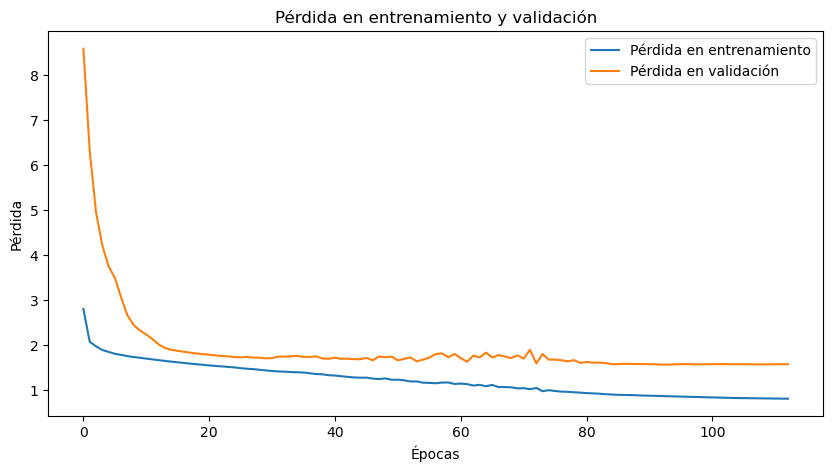

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Pérdida en entrenamiento')
plt.plot(range(len(val_losses)), val_losses, label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida en entrenamiento y validación')
plt.legend()
plt.show()

## Predicción
Se define la función de predicción para la red neuronal. Esta función realiza la propagación hacia adelante a través de todas las capas utilizando los parámetros aprendidos y devuelve las predicciones finales.

In [38]:
def predict(X):
    Z1 = np.dot(X, W1) + b1
    Z1_bn, _, _, _ = batch_norm_forward(Z1, gamma1, beta1, running_mean1, running_var1, training=False)
    A1 = relu(Z1_bn)
    Z2 = np.dot(A1, W2) + b2
    Z2_bn, _, _, _ = batch_norm_forward(Z2, gamma2, beta2, running_mean2, running_var2, training=False)
    A2 = relu(Z2_bn)
    Z3 = np.dot(A2, W3) + b3
    Z3_bn, _, _, _ = batch_norm_forward(Z3, gamma3, beta3, running_mean3, running_var3, training=False)
    A3 = relu(Z3_bn)
    Z4 = np.dot(A3, W4) + b4
    Z4_bn, _, _, _ = batch_norm_forward(Z4, gamma4, beta4, running_mean4, running_var4, training=False)
    Y_hat = softmax(Z4_bn)
    return np.argmax(Y_hat, axis=1)

In [39]:
y_test_pred = predict(X_test_flat)
print(y_test_pred)

[1 0 1 ... 7 7 4]


Se crea archivo CSV con el formato para el submission de kaggle.

In [40]:
predictions_df = pd.DataFrame({
    'ID': np.arange(len(y_test_pred)),
    'label': y_test_pred
})

In [41]:
predictions_df.to_csv('submission.csv', index=False)

### Valor de las métricas

In [42]:
print('Train metrics')
y_train_pred = predict(X_train_flat)
precisions, recalls, accuracy = metrics(y_train_pred, np.argmax(y_train_one_hot, axis=1), num_classes)
print(f"Overall Accuracy: {accuracy:.4f}")
for i in range(num_classes):
    print(f"Class {i} - Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}")
print('Val metrics')
y_train_pred = predict(X_val)
precisions, recalls, accuracy = metrics(y_train_pred, np.argmax(y_val, axis=1), num_classes)
print(f"Overall Accuracy: {accuracy:.4f}")
for i in range(num_classes):
    print(f"Class {i} - Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}")

Train metrics
Overall Accuracy: 0.8812
Class 0 - Precision: 0.8465, Recall: 0.8360
Class 1 - Precision: 0.9138, Recall: 0.9353
Class 2 - Precision: 0.8508, Recall: 0.8607
Class 3 - Precision: 0.8594, Recall: 0.8778
Class 4 - Precision: 0.8218, Recall: 0.8379
Class 5 - Precision: 0.9163, Recall: 0.8763
Class 6 - Precision: 0.8434, Recall: 0.9107
Class 7 - Precision: 0.9405, Recall: 0.8995
Class 8 - Precision: 0.9013, Recall: 0.8734
Class 9 - Precision: 0.9280, Recall: 0.9043
Val metrics
Overall Accuracy: 0.5267
Class 0 - Precision: 0.6168, Recall: 0.5833
Class 1 - Precision: 0.6158, Recall: 0.6437
Class 2 - Precision: 0.4303, Recall: 0.4148
Class 3 - Precision: 0.3588, Recall: 0.3803
Class 4 - Precision: 0.4387, Recall: 0.4729
Class 5 - Precision: 0.4248, Recall: 0.4101
Class 6 - Precision: 0.5320, Recall: 0.6311
Class 7 - Precision: 0.6086, Recall: 0.5581
Class 8 - Precision: 0.6600, Recall: 0.6127
Class 9 - Precision: 0.6211, Recall: 0.5719
